<a href="https://colab.research.google.com/github/anjalipatel101/481_Project_Fall_2023/blob/dog_yn/new_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras

In [ ]:
!pip install opendatasets
!pip install pandas

In [6]:
!pip install -q kaggle


!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download imsparsh/animal-breed-cats-and-dogs

100% 750M/753M [00:06<00:00, 165MB/s]
100% 753M/753M [00:06<00:00, 120MB/s]


In [ ]:
!unzip animal-breed-cats-and-dogs.zip

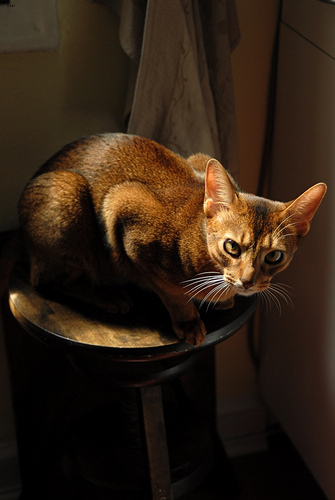

In [35]:
## TEST to get an image Display ##
import pathlib
import os
import imghdr
data_dir = '/content/data_dir/TRAIN'

def get_path_from_animal_name(name: str):
  path = f'{data_dir}/{name}/'
  return pathlib.Path(path)

def get_images_from_animal_name(name: str):
  path = get_path_from_animal_name(name)
  return list(path.glob('*.jpg'))

cat_imgs = get_images_from_animal_name('abyssinian')
PIL.Image.open(str(cat_imgs[0]))

In [36]:
batch_size = 32
img_height = 180
img_width = 180

In [58]:
## IDETIFYING THE TRAINING DATASET ##
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5890 files belonging to 37 classes.
Using 4712 files for training.


In [59]:
## IDENTOFYING THE VALIDATION DATASET ##
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5890 files belonging to 37 classes.
Using 1178 files for validation.


In [60]:
## GET THE CLASS ATTRIBUTE NAMES ##
class_names = train_ds.class_names
print(class_names)

['abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'bengal', 'birman', 'bombay', 'boxer', 'british_shorthair', 'chihuahua', 'egyptian_mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'maine_coon', 'miniature_pinscher', 'newfoundland', 'persian', 'pomeranian', 'pug', 'ragdoll', 'russian_blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'siamese', 'sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


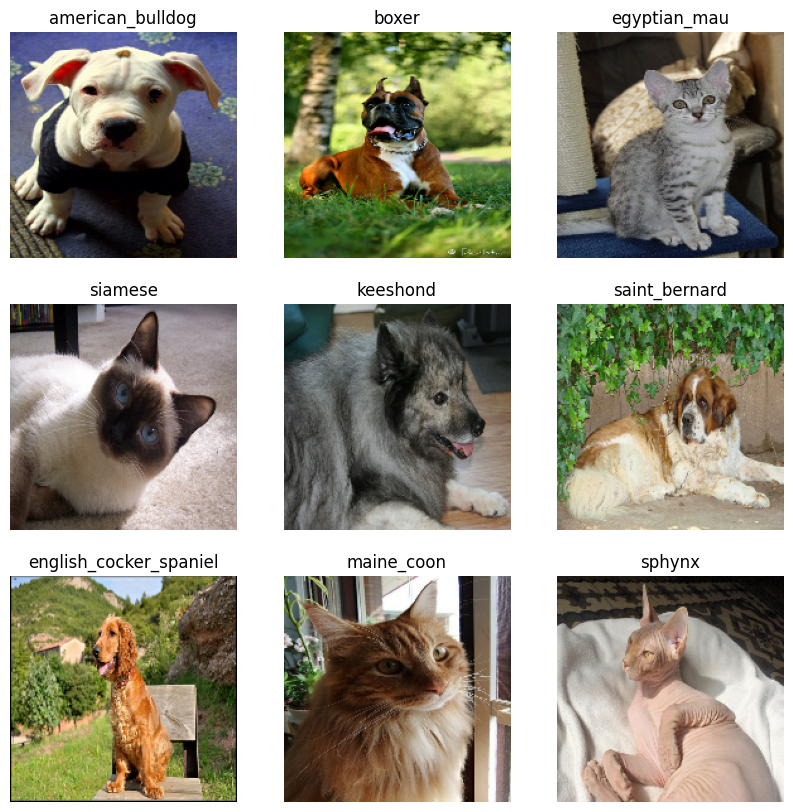

In [62]:
## VISUALIZE DATA FIRST 9 ##
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [63]:
## ITERATE ##
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [52]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [50]:
## CONFIGURE ##
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [53]:
## STANDERIZE DATA ##
normalization_layer = layers.Rescaling(1./255)

In [54]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [64]:
## KERAS MODEL ##
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [65]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [66]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [67]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
148/148 [==============================] - 170s 1s/step - loss: 3.5939 - accuracy: 0.0416 - val_loss: 3.4569 - val_accuracy: 0.0611
Epoch 2/10
148/148 [==============================] - 168s 1s/step - loss: 3.2338 - accuracy: 0.1286 - val_loss: 3.3078 - val_accuracy: 0.1078
Epoch 3/10
148/148 [==============================] - 170s 1s/step - loss: 2.6848 - accuracy: 0.2523 - val_loss: 3.4227 - val_accuracy: 0.1265
Epoch 4/10
148/148 [==============================] - 175s 1s/step - loss: 1.9430 - accuracy: 0.4469 - val_loss: 3.9151 - val_accuracy: 0.1426
Epoch 5/10
148/148 [==============================] - 164s 1s/step - loss: 1.1499 - accuracy: 0.6702 - val_loss: 5.3261 - val_accuracy: 0.1409
Epoch 6/10
148/148 [==============================] - 162s 1s/step - loss: 0.6020 - accuracy: 0.8262 - val_loss: 6.5035 - val_accuracy: 0.1324
Epoch 7/10
148/148 [==============================] - 171s 1s/step - loss: 0.3468 - accuracy: 0.9017 - val_loss: 7.2996 - val_accuracy: 0.1197

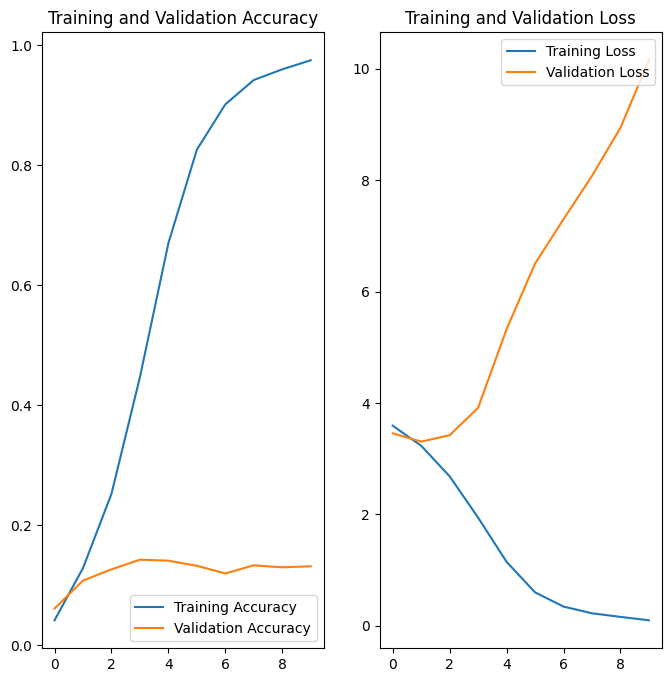

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [69]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

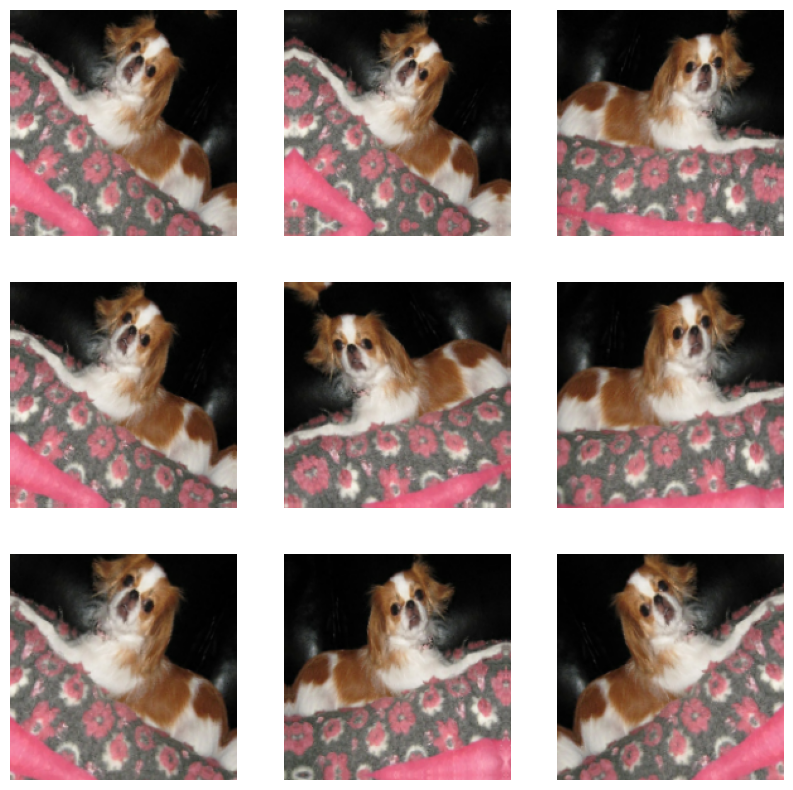

In [70]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## TESTING NEW ##

In [77]:
batch_size = 37
image_height = 180
image_width = 180

In [78]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255) # Other augmentations can be added here
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/data_dir/TRAIN',
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'  # Change this based on your problem type
)

test_generator = test_datagen.flow_from_directory(
    '/content/data_dir/TEST',
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 5890 images belonging to 37 classes.
Found 0 images belonging to 0 classes.
